In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import random
import numba
import statsmodels.api as sm
from sklearn.metrics import r2_score
import pandas as pd
import os
import sys
import scipy.stats as stats

# Step 1: Add parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "/scratch/ivyglade/pdo/"))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Step 2: Now you can import file.py
import pdo_functions  # assuming file.py contains functions/classes

import importlib
importlib.reload(pdo_functions)

<module 'pdo_functions' from '/scratch/ivyglade/pdo/pdo_functions.py'>

In [2]:
# Open environmental data
cape = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/wrf_cape/era5_daily_max_mucape_*s.nc', combine='nested', concat_dim='year')['__xarray_dataarray_variable__']
s06 = xr.open_mfdataset('/hurrell-scratch2/ivyglade/pdo/ERA5_S06/era5_s06_*s.nc', combine='nested', concat_dim='time')['__xarray_dataarray_variable__']
ndsev = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ndsev/ndsev_1940-2024_mam_corrected.nc')['__xarray_dataarray_variable__']

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.39.0 or higher is recommended. You are running version 2.30.0
  warnings.warn(


In [3]:
# Need to compute monthly means
ndsev_monthly = np.zeros((85, 101, 237))
for i in range(85):
    # Load in one year of data
    ndsev_monthly[i] = ndsev.isel(time=slice(i*92, (i+1)*92)).transpose('time', 'latitude', 'longitude').values.sum(axis=0)
    
    # Progress
    print(f'{1940+i} is complete.')

1940 is complete.
1941 is complete.
1942 is complete.
1943 is complete.
1944 is complete.
1945 is complete.
1946 is complete.
1947 is complete.
1948 is complete.
1949 is complete.
1950 is complete.
1951 is complete.
1952 is complete.
1953 is complete.
1954 is complete.
1955 is complete.
1956 is complete.
1957 is complete.
1958 is complete.
1959 is complete.
1960 is complete.
1961 is complete.
1962 is complete.
1963 is complete.
1964 is complete.
1965 is complete.
1966 is complete.
1967 is complete.
1968 is complete.
1969 is complete.
1970 is complete.
1971 is complete.
1972 is complete.
1973 is complete.
1974 is complete.
1975 is complete.
1976 is complete.
1977 is complete.
1978 is complete.
1979 is complete.
1980 is complete.
1981 is complete.
1982 is complete.
1983 is complete.
1984 is complete.
1985 is complete.
1986 is complete.
1987 is complete.
1988 is complete.
1989 is complete.
1990 is complete.
1991 is complete.
1992 is complete.
1993 is complete.
1994 is complete.
1995 is co

In [4]:
# Select the CONUS - making sure that CAPE, S06 and NDSEV all have the same shape
cape_conus = cape.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
s06_conus  = s06.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [5]:
# Select MAM only
cape_conus_mam = cape_conus.sel(date=cape_conus.date.where(
                                     cape_conus.date.str.startswith('03-') |
                                     cape_conus.date.str.startswith('04-') |
                                     cape_conus.date.str.startswith('05-'),
                                     drop=True)).load()

s06_conus_mam = s06_conus.sel(time=s06_conus.time.dt.month.isin([3, 4, 5]))

In [6]:
# Flatten to have a single time dimension
cape_conus_mam_mean_stack = cape_conus_mam.stack(time=('year', 'date'))

# Convert time to datetime
year = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('year')
date = cape_conus_mam_mean_stack['time'].get_index('time').get_level_values('date')

datetime = pd.to_datetime(year.astype(str) + '-' + date.astype(str))

cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)

/tmp/ipykernel_52071/906048647.py:10: FutureWarning: updating coordinate 'time' with a PandasMultiIndex would leave the multi-index level coordinates ['year', 'date'] in an inconsistent state. This will raise an error in the future. Use `.drop_vars(['time', 'year', 'date'])` before assigning new coordinate values.
  cape_conus_mam_mean_stack = cape_conus_mam_mean_stack.assign_coords(time=datetime)


In [7]:
# Take MAM mean
s06_conus_mam_mean = s06_conus_mam.resample(time='YE').mean().dropna(dim='time')
cape_conus_mam_mean = cape_conus_mam_mean_stack.resample(time='YE').mean().dropna(dim='time').transpose('time', 'latitude', 'longitude')

In [8]:
# Convert ndsev_monthly to XR
ndsev_conus = xr.DataArray(ndsev_monthly, coords={'time':cape_conus_mam_mean['time'], 'latitude':s06_conus_mam_mean['latitude'], 'longitude':s06_conus_mam_mean['longitude']}, dims=['time', 'latitude', 'longitude'])

In [9]:
# Detrend
cape_conus_mam_de = pdo_functions.detrend_dim(cape_conus_mam_mean, 'time', 2)
s06_conus_mam_de  = pdo_functions.detrend_dim(s06_conus_mam_mean, 'time', 2).load()
ndsev_conus_mam_de = pdo_functions.detrend_dim(ndsev_conus, 'time', 2)

In [10]:
# # Want to select a random lat/lon - to test if data is normally distributed
# lat_val1 = np.random.choice(s06_conus_mam_de['latitude'].values)
# lon_val1 = np.random.choice(s06_conus_mam_de['longitude'].values)

# lat_val2 = np.random.choice(s06_conus_mam_de['latitude'].values)
# lon_val2 = np.random.choice(s06_conus_mam_de['longitude'].values)

# lat_val3 = np.random.choice(s06_conus_mam_de['latitude'].values)
# lon_val3 = np.random.choice(s06_conus_mam_de['longitude'].values)

# lat_val4 = np.random.choice(s06_conus_mam_de['latitude'].values)
# lon_val4 = np.random.choice(s06_conus_mam_de['longitude'].values)

# cape_test1 = cape_conus_mam_de.sel(latitude=lat_val1, longitude=lon_val1, method='nearest')
# cape_test2 = cape_conus_mam_de.sel(latitude=lat_val2, longitude=lon_val2, method='nearest')
# cape_test3 = cape_conus_mam_de.sel(latitude=lat_val3, longitude=lon_val3, method='nearest')
# cape_test4 = cape_conus_mam_de.sel(latitude=lat_val4, longitude=lon_val4, method='nearest')

# s06_test1 = s06_conus_mam_de.sel(latitude=lat_val1, longitude=lon_val1, method='nearest')
# s06_test2 = s06_conus_mam_de.sel(latitude=lat_val2, longitude=lon_val2, method='nearest')
# s06_test3 = s06_conus_mam_de.sel(latitude=lat_val3, longitude=lon_val3, method='nearest')
# s06_test4 = s06_conus_mam_de.sel(latitude=lat_val4, longitude=lon_val4, method='nearest')

# ndsev_test1 = ndsev_conus_mam_de.sel(latitude=lat_val1, longitude=lon_val1, method='nearest')
# ndsev_test2 = ndsev_conus_mam_de.sel(latitude=lat_val2, longitude=lon_val2, method='nearest')
# ndsev_test3 = ndsev_conus_mam_de.sel(latitude=lat_val3, longitude=lon_val3, method='nearest')
# ndsev_test4 = ndsev_conus_mam_de.sel(latitude=lat_val4, longitude=lon_val4, method='nearest')

In [11]:
# def acf_and_tau(series, nlags=20):
#     # series: 1D numpy array (years) with no NaNs, mean removed
#     series = series - np.nanmean(series)
#     n = len(series)
#     acf = np.array([np.corrcoef(series[:-lag], series[lag:])[0,1] if lag>0 else 1.0
#                     for lag in range(nlags+1)])
#     # stop when acf becomes nan or negligible
#     # compute integral timescale tau summing until first negative crossing or nlags
#     positive_acf = acf[1:]  # omit lag-0
#     # find index of first negative crossing (if any)
#     neg_idx = np.where(positive_acf <= 0)[0]
#     if len(neg_idx) > 0:
#         M = neg_idx[0]
#     else:
#         M = nlags
#     tau = 1 + 2.0 * np.nansum(positive_acf[:M])
#     return acf, tau

In [12]:
# fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

# cape_bounds = np.arange(0, 1575, 75)
# s06_bounds = np.arange(0, 31.5, 1.5)
# ndsev_bounds = np.arange(0, 12.6, 0.6)

# cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('Reds').N)
# s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('Reds').N)
# ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('Reds').N)

# for i in range(3):
#     ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
#     ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
#     ax[i].set_facecolor('xkcd:light gray')
#     ax[i].spines['geo'].set_linewidth(0)

# ax[0].pcolormesh(cape_conus_mam_de['longitude'], cape_conus_mam_de['latitude'], cape_conus_mam_mean.mean(dim='time'), transform=ccrs.PlateCarree(), norm=cape_norm, cmap="Reds")
# ax[1].pcolormesh(cape_conus_mam_de['longitude'], cape_conus_mam_de['latitude'], s06_conus_mam_mean.mean(dim='time'), transform=ccrs.PlateCarree(), norm=s06_norm, cmap='Reds')
# ax[2].pcolormesh(cape_conus_mam_de['longitude'], cape_conus_mam_de['latitude'], ndsev_conus.mean(dim='time'), transform=ccrs.PlateCarree(), norm=ndsev_norm, cmap='Reds')

# ax[0].set_title('CAPE', pad=3)
# ax[1].set_title('S06', pad=3)
# ax[2].set_title('NDSEV', pad=3)

# ax[0].plot(cape_test1['longitude'], cape_test1['latitude'], transform=ccrs.PlateCarree(), color='pink', markersize=5, marker='X')
# ax[0].plot(cape_test2['longitude'], cape_test2['latitude'], transform=ccrs.PlateCarree(), color='black', markersize=5, marker='X')
# ax[0].plot(cape_test3['longitude'], cape_test3['latitude'], transform=ccrs.PlateCarree(), color='orange', markersize=5, marker='X')
# ax[0].plot(cape_test4['longitude'], cape_test4['latitude'], transform=ccrs.PlateCarree(), color='green', markersize=5, marker='X')

# ax[1].plot(cape_test1['longitude'], cape_test1['latitude'], transform=ccrs.PlateCarree(), color='pink', markersize=5, marker='X')
# ax[1].plot(cape_test2['longitude'], cape_test2['latitude'], transform=ccrs.PlateCarree(), color='black', markersize=5, marker='X')
# ax[1].plot(cape_test3['longitude'], cape_test3['latitude'], transform=ccrs.PlateCarree(), color='orange', markersize=5, marker='X')
# ax[1].plot(cape_test4['longitude'], cape_test4['latitude'], transform=ccrs.PlateCarree(), color='green', markersize=5, marker='X')

# ax[2].plot(cape_test1['longitude'], cape_test1['latitude'], transform=ccrs.PlateCarree(), color='pink', markersize=5, marker='X')
# ax[2].plot(cape_test2['longitude'], cape_test2['latitude'], transform=ccrs.PlateCarree(), color='black', markersize=5, marker='X')
# ax[2].plot(cape_test3['longitude'], cape_test3['latitude'], transform=ccrs.PlateCarree(), color='orange', markersize=5, marker='X')
# ax[2].plot(cape_test4['longitude'], cape_test4['latitude'], transform=ccrs.PlateCarree(), color='green', markersize=5, marker='X')

In [13]:
# Suppose your series is in a 1D array or pandas Series called x
# acf_values1 = sm.tsa.acf(s06_test1, nlags=40, fft=True)
# acf_values2 = sm.tsa.acf(s06_test2, nlags=40, fft=True)
# acf_values3 = sm.tsa.acf(s06_test3, nlags=40, fft=True)
# acf_values4 = sm.tsa.acf(s06_test4, nlags=40, fft=True)

# fig, ax = plt.subplots(2, 2, figsize=(12, 8))

# # Plot autocorrelation
# sm.graphics.tsa.plot_acf(ndsev_test1, lags=40, ax=ax[0, 0])
# sm.graphics.tsa.plot_acf(ndsev_test2, lags=40, ax=ax[0, 1] )
# sm.graphics.tsa.plot_acf(ndsev_test3, lags=40, ax=ax[1, 0] )
# sm.graphics.tsa.plot_acf(ndsev_test4, lags=40, ax=ax[1, 1] )

# ax[0, 0].set_title('Pink X')
# ax[0, 1].set_title('Black X')
# ax[1, 0].set_title('Orange X')
# ax[1, 1].set_title('Green X')

# plt.show()

In [14]:
# Some testing 
# test1_vals = ndsev_test1.values
# test2_vals = ndsev_test1.values
# test3_vals = ndsev_test2.values
# test4_vals = ndsev_test4.values

# n = len(test1_vals)
# B = 10000

# boot_samples1 = np.random.choice(test1_vals, size=(B, n), replace=True)
# boot_samples2 = np.random.choice(test2_vals, size=(B, n), replace=True)
# boot_samples3 = np.random.choice(test3_vals, size=(B, n), replace=True)
# boot_samples4 = np.random.choice(test4_vals, size=(B, n), replace=True)

# boot_means1 = boot_samples1.mean(axis=1)
# boot_means2 = boot_samples2.mean(axis=1)
# boot_means3 = boot_samples3.mean(axis=1)
# boot_means4 = boot_samples4.mean(axis=1)

In [15]:
# fig, ax = plt.subplots(2, 2, figsize=(12, 9))

# stats.probplot(boot_means1, dist="norm", plot=ax[0, 0])
# stats.probplot(boot_means2, dist="norm", plot=ax[0, 1])
# stats.probplot(boot_means3, dist="norm", plot=ax[1, 0])
# stats.probplot(boot_means4, dist="norm", plot=ax[1, 1])

# ax[0, 0].set_title('Pink X Q-Q', pad=3)
# ax[0, 1].set_title('Black X Q-Q', pad=3)
# ax[1, 0].set_title('Orange X Q-Q', pad=3)
# ax[1, 1].set_title('Green X Q-Q', pad=3)


# # plt.title("Q–Q plot of bootstrap sample means")
# plt.show()

In [16]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1870, 2024)

oni = pdo_functions.oni_moving_base(sst)

In [17]:
# 3- month rolling mean
oni_rolling = oni.rolling(time=3, center=True).mean()
oni_rolling_1940_2024 = oni_rolling.sel(time=oni_rolling.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_rolling_1940_2024_mam = oni_rolling_1940_2024.sel(time=oni_rolling_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# Calculating when El Nino and La Nina events occur
oni_calc = np.zeros((1668))
for i in range(1668):
    if i < 5:
        continue
    else:
        if (oni_rolling[(i-4)] > 0.5) & (oni_rolling[(i-3)] > 0.5) & (oni_rolling[(i-2)] > 0.5) & (oni_rolling[(i-1)] > 0.5) & (oni_rolling[i] > 0.5):
            oni_calc[i] = 1
        elif (oni_rolling[(i-4)] < -0.5) & (oni_rolling[(i-3)] < -0.5) & (oni_rolling[(i-2)] < -0.5) & (oni_rolling[(i-1)] < -0.5) & (oni_rolling[i] < -0.5):
            oni_calc[i] = -1
        else:
            continue

# Coonvert to XR
oni_calc_xr = xr.DataArray(oni_calc, coords={'time':oni['time']}, dims=['time'])

# 1940-2024 only
oni_1940_2024 = oni_calc_xr.sel(time=oni_calc_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
oni_1940_2024_mam = oni_1940_2024.sel(time=oni_1940_2024.time.dt.month.isin([3, 4, 5]))

# Need to calculate when El Nino/La Nina Occurs in a given year
oni_1940_2024_mam_ann = np.zeros((85))
for i in range(85):
    if oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) > 0:
        oni_1940_2024_mam_ann[i] = 1

    elif oni_1940_2024_mam[i*3: (i+1)*3].sum(axis=0) < 0:
        oni_1940_2024_mam_ann[i] = -1

    else:
        continue

In [18]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':sst['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM and take seasonal averages
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).resample(time='YE').mean()

# aligning time arrays with that of CAPE
pdo_1940_2024_mam['time'] = cape_conus_mam_de['time']

s06_conus_mam_de['time'] = cape_conus_mam_de['time']
oni_rolling_1940_2024_mam['time'] = cape_conus_mam_de['time']

oni_ann_xr = xr.DataArray(oni_1940_2024_mam_ann, coords={'time':cape_conus_mam_de['time']}, dims=['time'])

In [19]:
# Percent variance explained
cape_var = pdo_functions.linregress_3D(pdo_1940_2024_mam.values, cape_conus_mam_de.values)[1] **2
s06_var = pdo_functions.linregress_3D(pdo_1940_2024_mam.values, s06_conus_mam_de.values)[1] **2
ndsev_var = pdo_functions.linregress_3D(pdo_1940_2024_mam.values, ndsev_conus_mam_de.values)[1] **2

In [20]:
# full cmap
full_cmap = cmr.fusion_r

redside = c.LinearSegmentedColormap.from_list('fusion_r_red', full_cmap(np.linspace(0.5, 1, 256)))

# Land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(cape_conus_mam_de, lon_name='longitude', lat_name='latitude')==True, 1, np.nan).squeeze()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


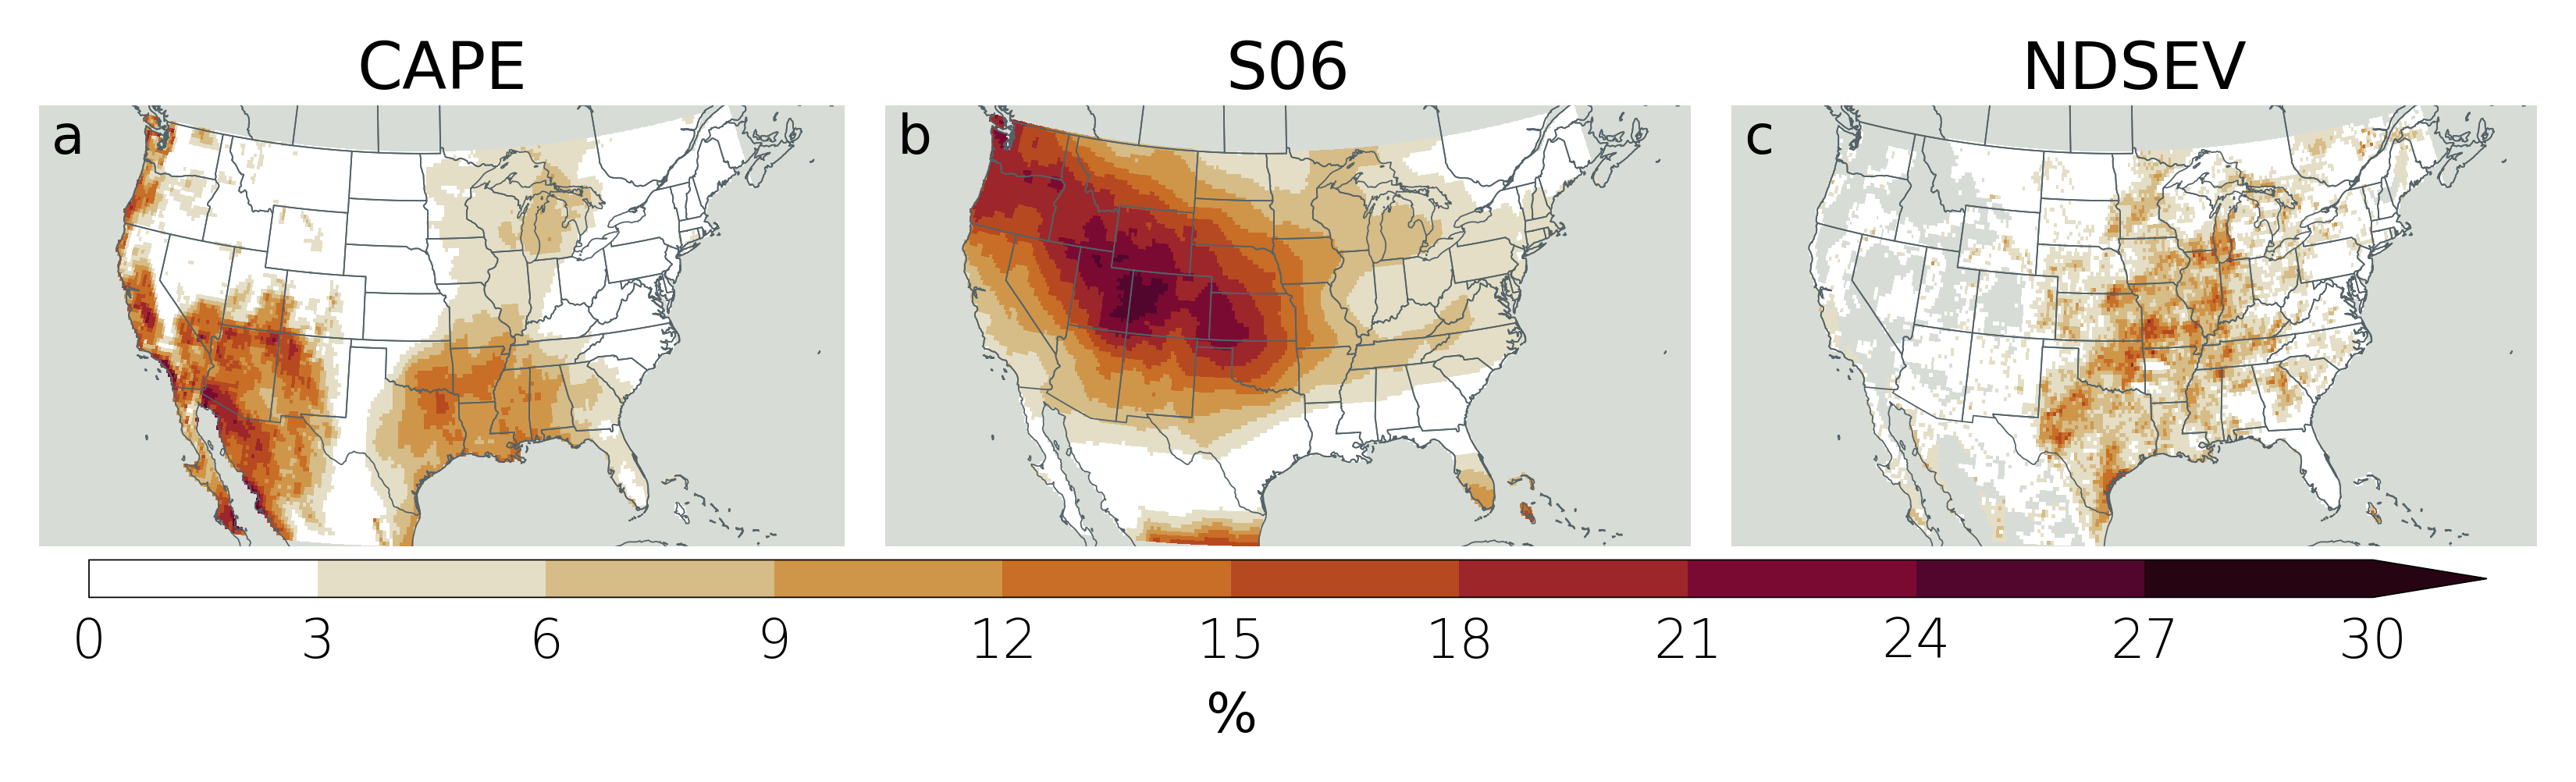

In [21]:
fig, ax = plt.subplots(1, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

bounds = np.arange(0, 33, 3)

norm = c.BoundaryNorm(bounds, redside.N)

letters = ['a', 'b', 'c']

for i in range(3):
    ax[i].coastlines(color='xkcd:gunmetal', lw=0.25)
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].add_feature(ct.feature.OCEAN, facecolor='xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)
    ax[i].set_facecolor('xkcd:light gray')

lon = cape_conus_mam_de['longitude']
lat = cape_conus_mam_de['latitude']

ax[0].pcolormesh(lon, lat, cape_var*land*100, transform=ccrs.PlateCarree(), norm=norm, cmap=redside)

ax[1].pcolormesh(lon, lat, s06_var*land*100, transform=ccrs.PlateCarree(), norm=norm, cmap=redside)

ax[2].pcolormesh(lon, lat, ndsev_var*land*100, transform=ccrs.PlateCarree(), norm=norm, cmap=redside)

cax = plt.axes([0.02, .23, 0.96, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap=redside, norm=norm), cax=cax, orientation='horizontal', spacing='proportional', extend='max', \
                    ticks=[0, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30])
cbar.set_label(r'%', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].set_title('CAPE', pad=3)
ax[1].set_title('S06', pad=3)
ax[2].set_title('NDSEV', pad=3)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.5, 
                    wspace=0.05, 
                    hspace=0.05)

fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/FigS6_perc_var_exp.png', bbox_inches='tight')

In [22]:
# Compositing
cape_pos_pdo = xr.where(pdo_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo = xr.where(pdo_1940_2024_mam < 0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_nino = xr.where(oni_ann_xr == 1, cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_nina = xr.where(oni_ann_xr == -1, cape_conus_mam_de, np.nan).dropna(dim='time')

cape_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), cape_conus_mam_de, np.nan).dropna(dim='time')
cape_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), cape_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo = xr.where(pdo_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo = xr.where(pdo_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_nino = xr.where(oni_ann_xr == 1, s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_nina = xr.where(oni_ann_xr == -1, s06_conus_mam_de, np.nan).dropna(dim='time')

s06_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), s06_conus_mam_de, np.nan).dropna(dim='time')
s06_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), s06_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo = xr.where(pdo_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo = xr.where(pdo_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_oni = xr.where(oni_rolling_1940_2024_mam > 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_oni = xr.where(oni_rolling_1940_2024_mam < 0, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_nino = xr.where(oni_ann_xr == 1, ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_nina = xr.where(oni_ann_xr == -1, ndsev_conus_mam_de, np.nan).dropna(dim='time')

ndsev_pos_pdo_neut_oni = xr.where((pdo_1940_2024_mam > 0) & (oni_ann_xr == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')
ndsev_neg_pdo_neut_oni = xr.where((pdo_1940_2024_mam < 0) & (oni_ann_xr == 0), ndsev_conus_mam_de, np.nan).dropna(dim='time')

In [23]:
def perm_p_vals(comp_data, climo_data, n_resamples):
    diff = comp_data.mean(dim='time') - climo_data.mean(dim='time')

    n_perms = n_resamples
    n_comp = len(comp_data['time'])
    perm_diffs = np.zeros((n_perms, 101, 237))

    for i in range(n_perms):
        fake_idx = np.random.choice(len(climo_data.time), size=n_comp, replace=False)
        fake_comp = climo_data.isel(time=fake_idx)

        perm_diffs[i] = (fake_comp.mean(dim='time') - climo_data.mean(dim='time'))

    p_values = np.mean(np.abs(perm_diffs) >= abs(diff.values), axis=0)

    return p_values

In [24]:
# cape_pos_pdo_p = perm_p_vals(cape_pos_pdo, cape_conus_mam_de, 10000)

In [25]:
# cape_neg_pdo_p = perm_p_vals(cape_neg_pdo, cape_conus_mam_de, 10000)

In [26]:
# s06_pos_pdo_p = perm_p_vals(s06_pos_pdo, s06_conus_mam_de, 10000)

In [27]:
# s06_neg_pdo_p = perm_p_vals(s06_neg_pdo, s06_conus_mam_de, 10000)

In [28]:
# ndsev_pos_pdo_p = perm_p_vals(ndsev_pos_pdo, ndsev_conus_mam_de, 10000)

In [29]:
# ndsev_neg_pdo_p = perm_p_vals(ndsev_neg_pdo, ndsev_conus_mam_de, 10000)

In [30]:
cape_pos_pdo_neut_oni_p = perm_p_vals(cape_pos_pdo_neut_oni, cape_conus_mam_de, 10000)

In [31]:
cape_neg_pdo_neut_oni_p = perm_p_vals(cape_neg_pdo_neut_oni, cape_conus_mam_de, 10000)

In [32]:
s06_pos_pdo_neut_oni_p = perm_p_vals(s06_pos_pdo_neut_oni, s06_conus_mam_de, 10000)

In [33]:
s06_neg_pdo_neut_oni_p = perm_p_vals(s06_neg_pdo_neut_oni, s06_conus_mam_de, 10000)

In [34]:
ndsev_pos_pdo_neut_oni_p = perm_p_vals(ndsev_pos_pdo_neut_oni, ndsev_conus_mam_de, 10000)

In [35]:
ndsev_neg_pdo_neut_oni_p = perm_p_vals(ndsev_neg_pdo_neut_oni, ndsev_conus_mam_de, 10000)

In [36]:
## SPACER ##

In [37]:
# cape_pos_pdo_adj_p = pdo_functions.control_FDR(cape_pos_pdo_p, 101, 237, 0.05)

In [38]:
# cape_neg_pdo_adj_p = pdo_functions.control_FDR(cape_neg_pdo_p, 101, 237, 0.05)

In [36]:
cape_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(cape_pos_pdo_neut_oni_p, 101, 237, 0.05)

In [37]:
cape_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(cape_neg_pdo_neut_oni_p, 101, 237, 0.05)

In [41]:
# s06_pos_pdo_adj_p = pdo_functions.control_FDR(s06_pos_pdo_p, 101, 237, 0.05)

In [42]:
# s06_neg_pdo_adj_p = pdo_functions.control_FDR(s06_neg_pdo_p, 101, 237, 0.05)

In [38]:
s06_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(s06_pos_pdo_neut_oni_p, 101, 237, 0.05)

In [39]:
s06_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(s06_neg_pdo_neut_oni_p, 101, 237, 0.05)

In [45]:
# ndsev_pos_pdo_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_p, 101, 237, 0.05)

In [46]:
# ndsev_neg_pdo_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_p, 101, 237, 0.05)

In [40]:
ndsev_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_neut_oni_p, 101, 237, 0.05)

In [41]:
ndsev_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_neut_oni_p, 101, 237, 0.05)

In [49]:
## SPACER ##

In [50]:
# cape_pos_pdo_sig = np.where(cape_pos_pdo_p <= cape_pos_pdo_adj_p, 1, 0)

In [51]:
# cape_neg_pdo_sig = np.where(cape_neg_pdo_p <= cape_neg_pdo_adj_p, 1, 0)

In [42]:
cape_pos_pdo_neut_oni_sig = np.where(cape_pos_pdo_neut_oni_p <= cape_pos_pdo_neut_oni_adj_p, 1, 0)

In [43]:
cape_neg_pdo_neut_oni_sig = np.where(cape_neg_pdo_neut_oni_p <= cape_neg_pdo_neut_oni_adj_p, 1, 0)

In [54]:
# s06_pos_pdo_sig = np.where(s06_pos_pdo_p <= s06_pos_pdo_adj_p, 1, 0)

In [55]:
# s06_neg_pdo_sig = np.where(s06_neg_pdo_p <= s06_neg_pdo_adj_p, 1, 0)

In [44]:
s06_pos_pdo_neut_oni_sig = np.where(s06_pos_pdo_neut_oni_p <= s06_pos_pdo_neut_oni_adj_p, 1, 0)

In [45]:
s06_neg_pdo_neut_oni_sig = np.where(s06_neg_pdo_neut_oni_p <= s06_neg_pdo_neut_oni_adj_p, 1, 0)

In [58]:
# ndsev_pos_pdo_sig = np.where(ndsev_pos_pdo_p <= ndsev_pos_pdo_adj_p, 1, 0)

In [59]:
# ndsev_neg_pdo_sig = np.where(ndsev_neg_pdo_p <= ndsev_neg_pdo_adj_p, 1, 0)

In [46]:
ndsev_pos_pdo_neut_oni_sig = np.where(ndsev_pos_pdo_neut_oni_p <= ndsev_pos_pdo_neut_oni_adj_p, 1, 0)

In [47]:
ndsev_neg_pdo_neut_oni_sig = np.where(ndsev_neg_pdo_neut_oni_p <= ndsev_neg_pdo_neut_oni_adj_p, 1, 0)

In [62]:
# Significance testing
# cape_pos_pdo_p = stats.ttest_ind(cape_pos_pdo, cape_conus_mam_de, equal_var=False, axis=0)[1]
# cape_neg_pdo_p = stats.ttest_ind(cape_neg_pdo, cape_conus_mam_de, equal_var=False, axis=0)[1]

# s06_pos_pdo_p = stats.ttest_ind(s06_pos_pdo, s06_conus_mam_de, equal_var=False, axis=0)[1]
# s06_neg_pdo_p = stats.ttest_ind(s06_neg_pdo, s06_conus_mam_de, equal_var=False, axis=0)[1]

# ndsev_pos_pdo_p = stats.ttest_ind(ndsev_pos_pdo, ndsev_conus_mam_de, equal_var=False, axis=0)[1]
# ndsev_neg_pdo_p = stats.ttest_ind(ndsev_neg_pdo, ndsev_conus_mam_de, equal_var=False, axis=0)[1]

# cape_pos_pdo_neut_oni_p = stats.ttest_ind(cape_pos_pdo_neut_oni, cape_conus_mam_de, equal_var=False, axis=0)[1]
# cape_neg_pdo_neut_oni_p = stats.ttest_ind(cape_neg_pdo_neut_oni, cape_conus_mam_de, equal_var=False, axis=0)[1]

# s06_pos_pdo_neut_oni_p = stats.ttest_ind(s06_pos_pdo_neut_oni, s06_conus_mam_de, equal_var=False, axis=0)[1]
# s06_neg_pdo_neut_oni_p = stats.ttest_ind(s06_neg_pdo_neut_oni, s06_conus_mam_de, equal_var=False, axis=0)[1]

# ndsev_pos_pdo_neut_oni_p = stats.ttest_ind(ndsev_pos_pdo_neut_oni, ndsev_conus_mam_de, equal_var=False, axis=0)[1]
# ndsev_neg_pdo_neut_oni_p = stats.ttest_ind(ndsev_neg_pdo_neut_oni, ndsev_conus_mam_de, equal_var=False, axis=0)[1]

In [63]:
# cape_pos_pdo_adj_p = pdo_functions.control_FDR(cape_pos_pdo_p, 101, 237, 0.15)
# cape_neg_pdo_adj_p = pdo_functions.control_FDR(cape_neg_pdo_p, 101, 237, 0.1)

# s06_pos_pdo_adj_p = pdo_functions.control_FDR(s06_pos_pdo_p, 101, 237, 0.1)
# s06_neg_pdo_adj_p = pdo_functions.control_FDR(s06_neg_pdo_p, 101, 237, 0.1)

# ndsev_pos_pdo_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_p, 101, 237, 0.1)
# ndsev_neg_pdo_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_p, 101, 237, 0.1)

# cape_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(cape_pos_pdo_neut_oni_p, 101, 237, 0.1)
# cape_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(cape_neg_pdo_neut_oni_p, 101, 237, 0.1)

# s06_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(s06_pos_pdo_neut_oni_p, 101, 237, 0.1)
# s06_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(s06_neg_pdo_neut_oni_p, 101, 237, 0.1)

# ndsev_pos_pdo_neut_oni_adj_p = pdo_functions.control_FDR(ndsev_pos_pdo_neut_oni_p, 101, 237, 0.1)
# ndsev_neg_pdo_neut_oni_adj_p = pdo_functions.control_FDR(ndsev_neg_pdo_neut_oni_p, 101, 237, 0.1)

In [64]:
# cape_pos_pdo_sig = np.where(cape_pos_pdo_p < cape_pos_pdo_adj_p, 1, 0)
# cape_neg_pdo_sig = np.where(cape_neg_pdo_p < cape_neg_pdo_adj_p, 1, 0)

# s06_pos_pdo_sig = np.where(s06_pos_pdo_p < s06_pos_pdo_adj_p, 1, 0)
# s06_neg_pdo_sig = np.where(s06_neg_pdo_p < s06_neg_pdo_adj_p, 1, 0)

# ndsev_pos_pdo_sig = np.where(ndsev_pos_pdo_p < ndsev_pos_pdo_adj_p, 1, 0)
# ndsev_neg_pdo_sig = np.where(ndsev_neg_pdo_p < ndsev_neg_pdo_adj_p, 1, 0)

# cape_pos_pdo_neut_oni_sig = np.where(cape_pos_pdo_neut_oni_p < cape_pos_pdo_neut_oni_adj_p, 1, 0)
# cape_neg_pdo_neut_oni_sig = np.where(cape_neg_pdo_neut_oni_p < cape_neg_pdo_neut_oni_adj_p, 1, 0)

# s06_pos_pdo_neut_oni_sig = np.where(s06_pos_pdo_neut_oni_p < s06_pos_pdo_neut_oni_adj_p, 1, 0)
# s06_neg_pdo_neut_oni_sig = np.where(s06_neg_pdo_neut_oni_p < s06_neg_pdo_neut_oni_adj_p, 1, 0)

# ndsev_pos_pdo_neut_oni_sig = np.where(ndsev_pos_pdo_neut_oni_p < ndsev_pos_pdo_neut_oni_adj_p, 1, 0)
# ndsev_neg_pdo_neut_oni_sig = np.where(ndsev_neg_pdo_neut_oni_p < ndsev_neg_pdo_neut_oni_adj_p, 1, 0)

In [24]:
# Land mask
land_110 = regionmask.defined_regions.natural_earth_v4_1_0.land_110
land = xr.where(land_110.mask_3D(cape_conus_mam_de, lon_name='longitude', lat_name='latitude')==True, 1, np.nan).squeeze()

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/regionmask/core/mask.py:179: FutureWarning: Passing 'lon_name' and 'lat_name' was deprecated in v0.10.0. Please pass the coordinates directly, e.g., `mask*(ds[lon_name], ds[lat_name])`.
  warnings.warn(


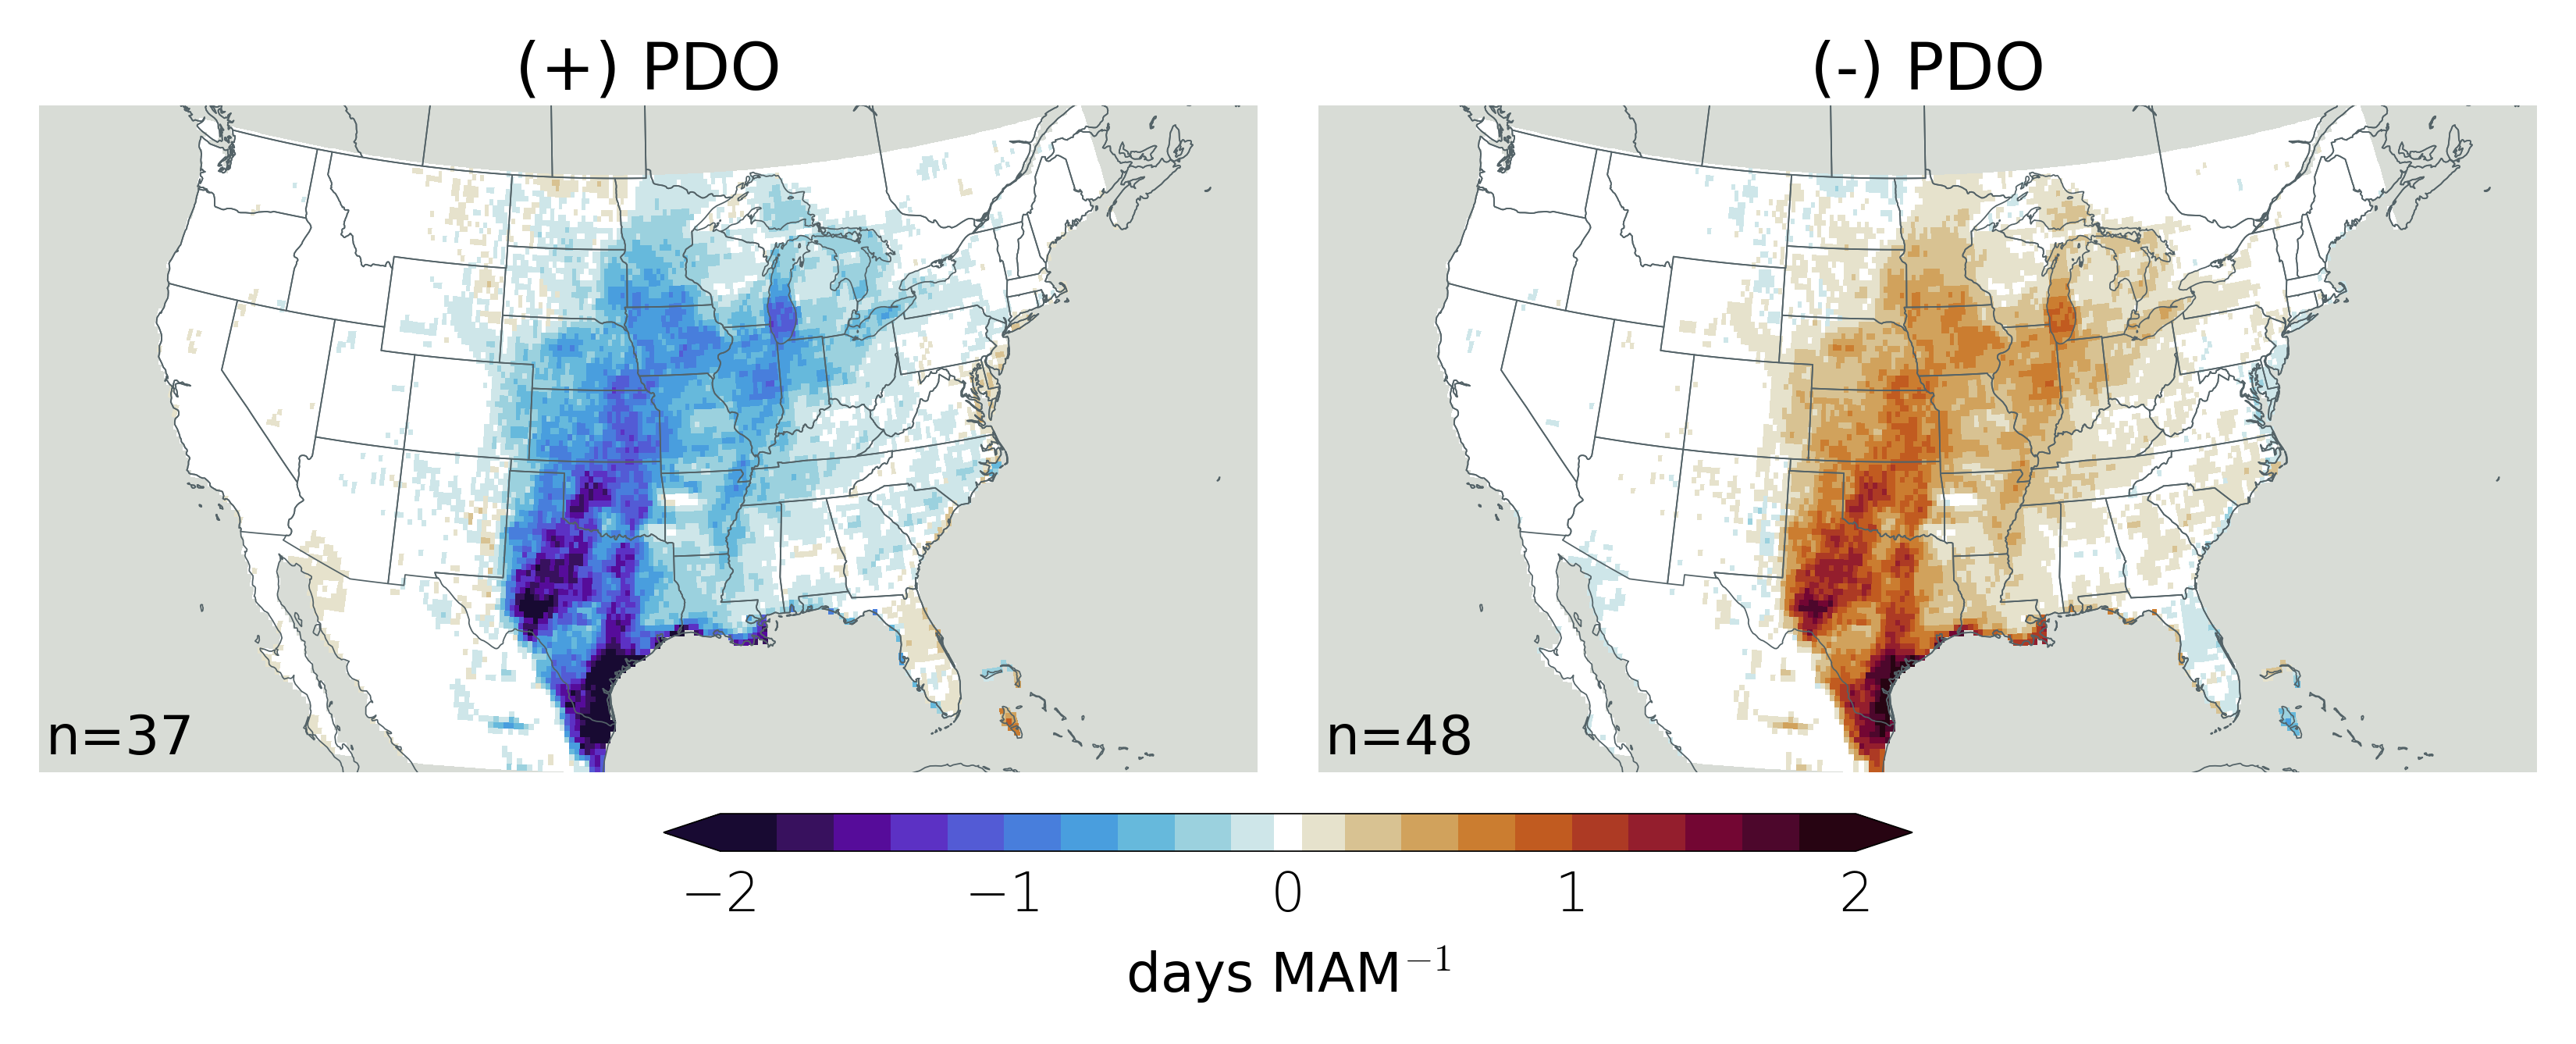

In [97]:
fig, ax = plt.subplots(1, 2, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ndsev_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)

lon = ndsev['longitude']
lat = ndsev['latitude']

for i in range(2):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')

ax[0].pcolormesh(lon, lat, ndsev_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[1].pcolormesh(lon, lat, ndsev_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

mpl.rcParams['hatch.color'] = 'black'
mpl.rcParams['hatch.linewidth'] = 0.375

ax[0].set_title('(+) PDO', pad=3)
ax[1].set_title('(-) PDO', pad=3)

cax3 = plt.axes([0.25, .23, 0.5, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[0].text(-2400000, -1350000, f"n={len(cape_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[1].text(-2400000, -1350000, f"n={len(cape_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.65, 
                    wspace=0.05, 
                    hspace=0.05)

fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/spatial_composite_ndsev_only.png', bbox_inches='tight')

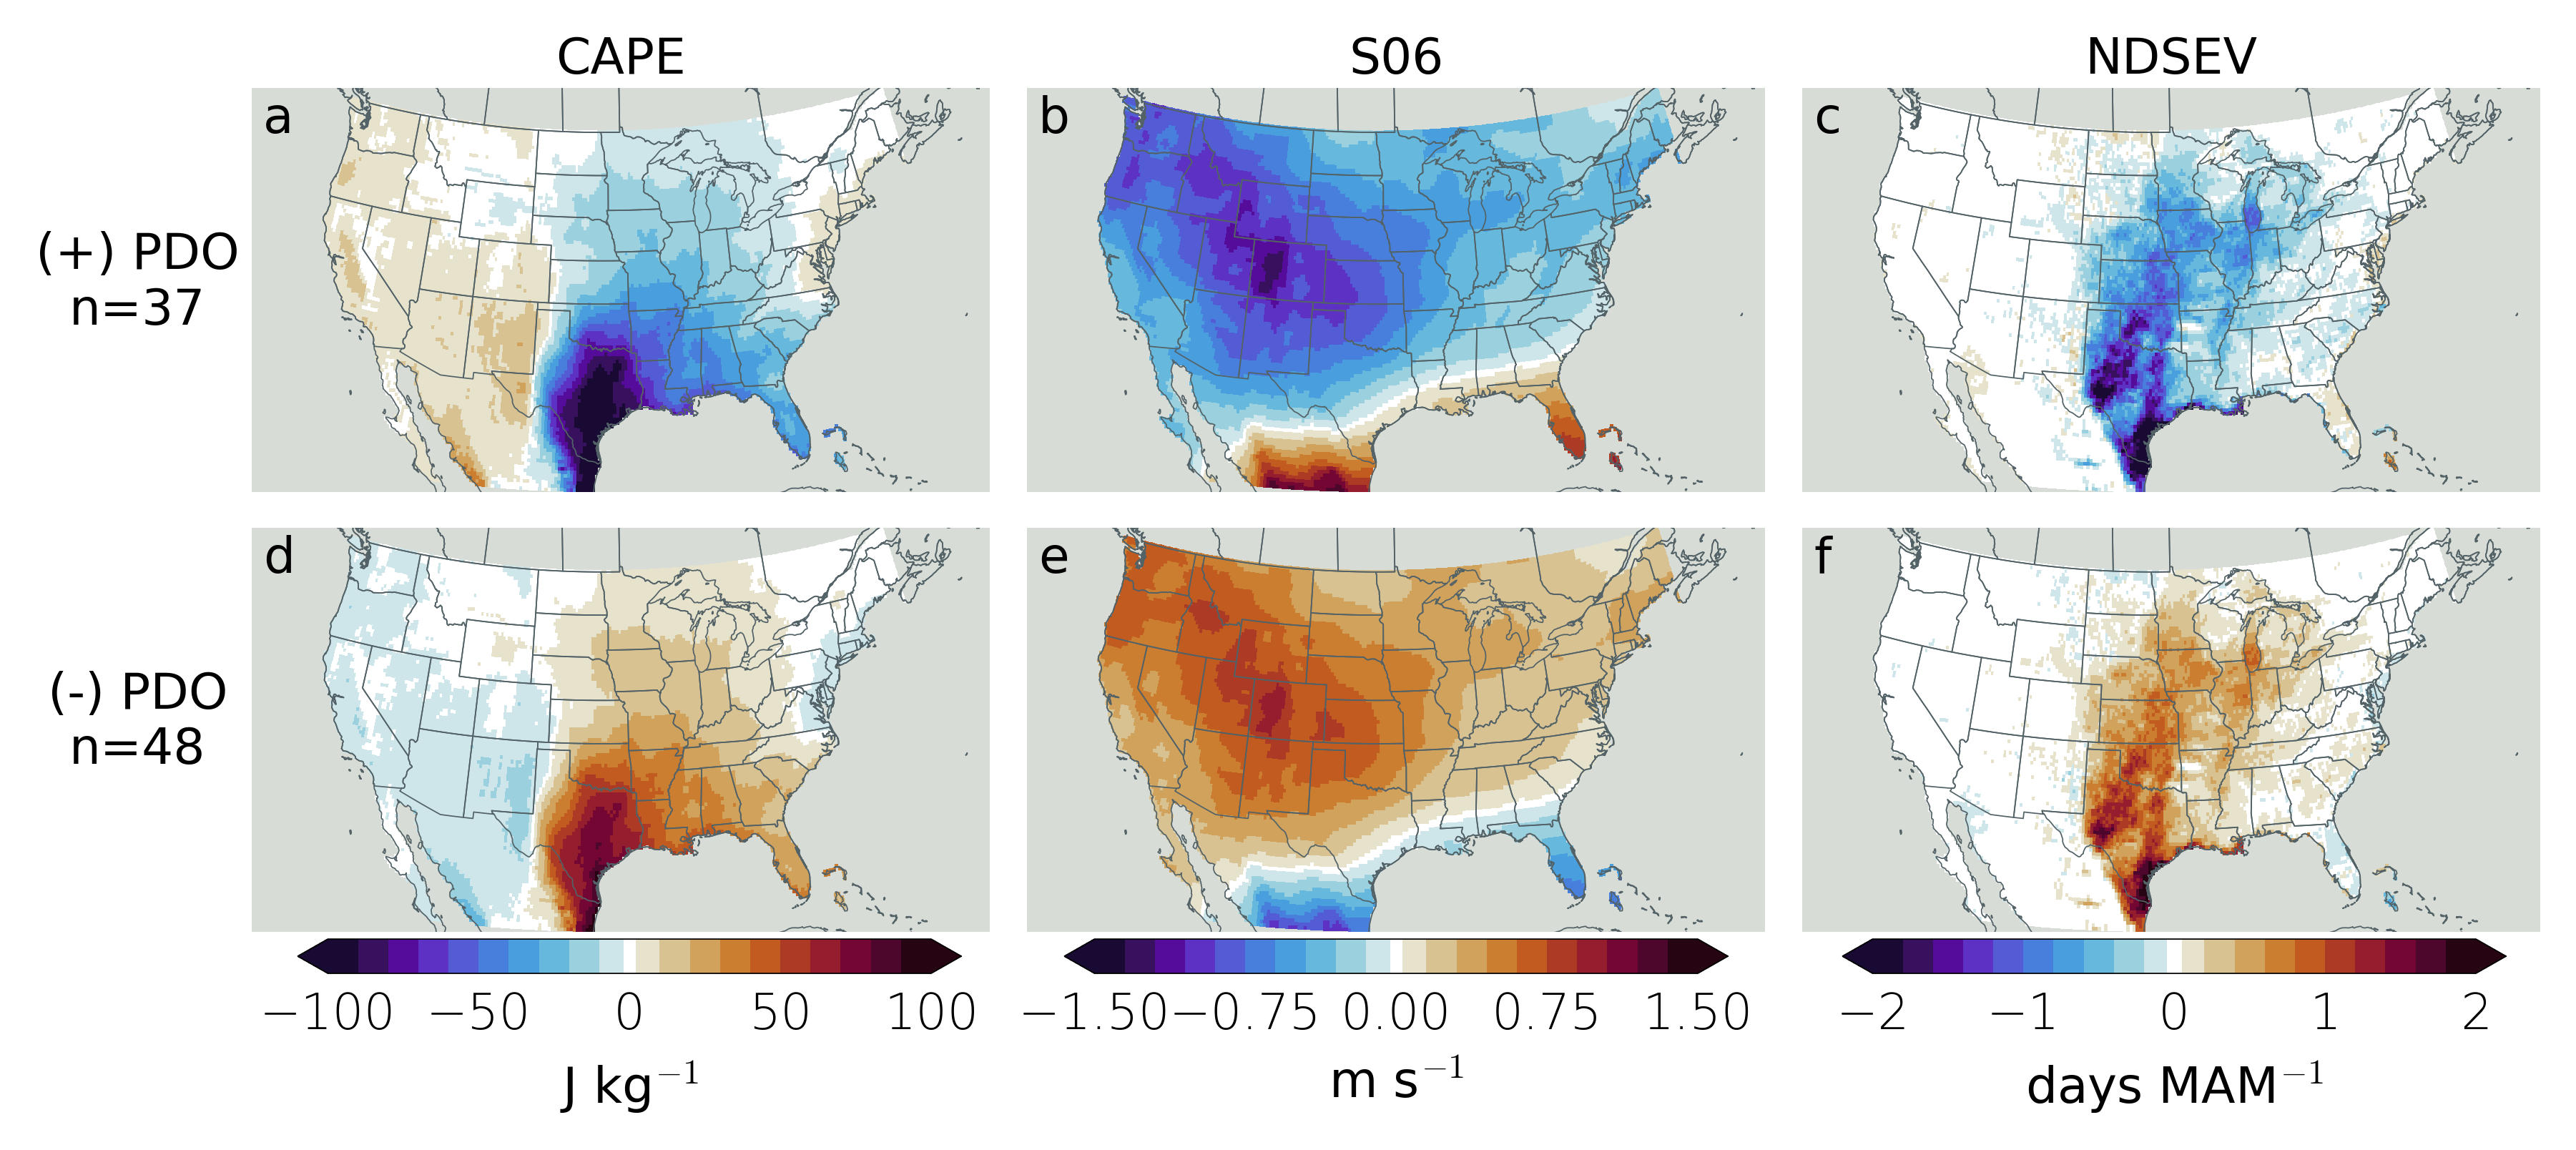

In [25]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ndsev_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)

cape_bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)

s06_bounds = [-1.5, -1.35, -1.2, -1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, -0.03, 0.03, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5]
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

lon = ndsev['longitude']
lat = ndsev['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f']

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, ndsev_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
# ax[5].pcolormesh(lon, lat, ndsev_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[5].pcolormesh(lon, lat, ndsev_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
# ax[11].pcolormesh(lon, lat, ndsev_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[0].pcolormesh(lon, lat, cape_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
# ax[3].pcolormesh(lon, lat, cape_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
ax[3].pcolormesh(lon, lat, cape_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
# ax[9].pcolormesh(lon, lat, cape_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[1].pcolormesh(lon, lat, s06_pos_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
# ax[4].pcolormesh(lon, lat, s06_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
ax[4].pcolormesh(lon, lat, s06_neg_pdo.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
# ax[10].pcolormesh(lon, lat, s06_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(cape_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
# ax[3].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(cape_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"(-) PDO\nn={len(cape_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
# ax[9].text(-4000000, -400000, f"(-) PDO &\nneutral ONI\nn={len(cape_neg_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

# ax[0].contourf(lon, lat, cape_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[3].contourf(lon, lat, cape_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[1].contourf(lon, lat, s06_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[4].contourf(lon, lat, s06_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[2].contourf(lon, lat, ndsev_pos_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[5].contourf(lon, lat, ndsev_neg_pdo_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-100, -50, 0, 50, 100])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-1.5, -0.75, 0, 0.75, 1.5])
cbar2.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

# lat_min, lat_max = 30, 47
# lon_min, lon_max = pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)
# rect_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
# rect_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
# ax[2].plot(rect_lons, rect_lats, color='black', lw=1, transform=ccrs.PlateCarree())

mpl.rcParams['hatch.color'] = 'black'
mpl.rcParams['hatch.linewidth'] = 0.375

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

# fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/Fig3_spatial_composite_no_box.png', bbox_inches='tight')

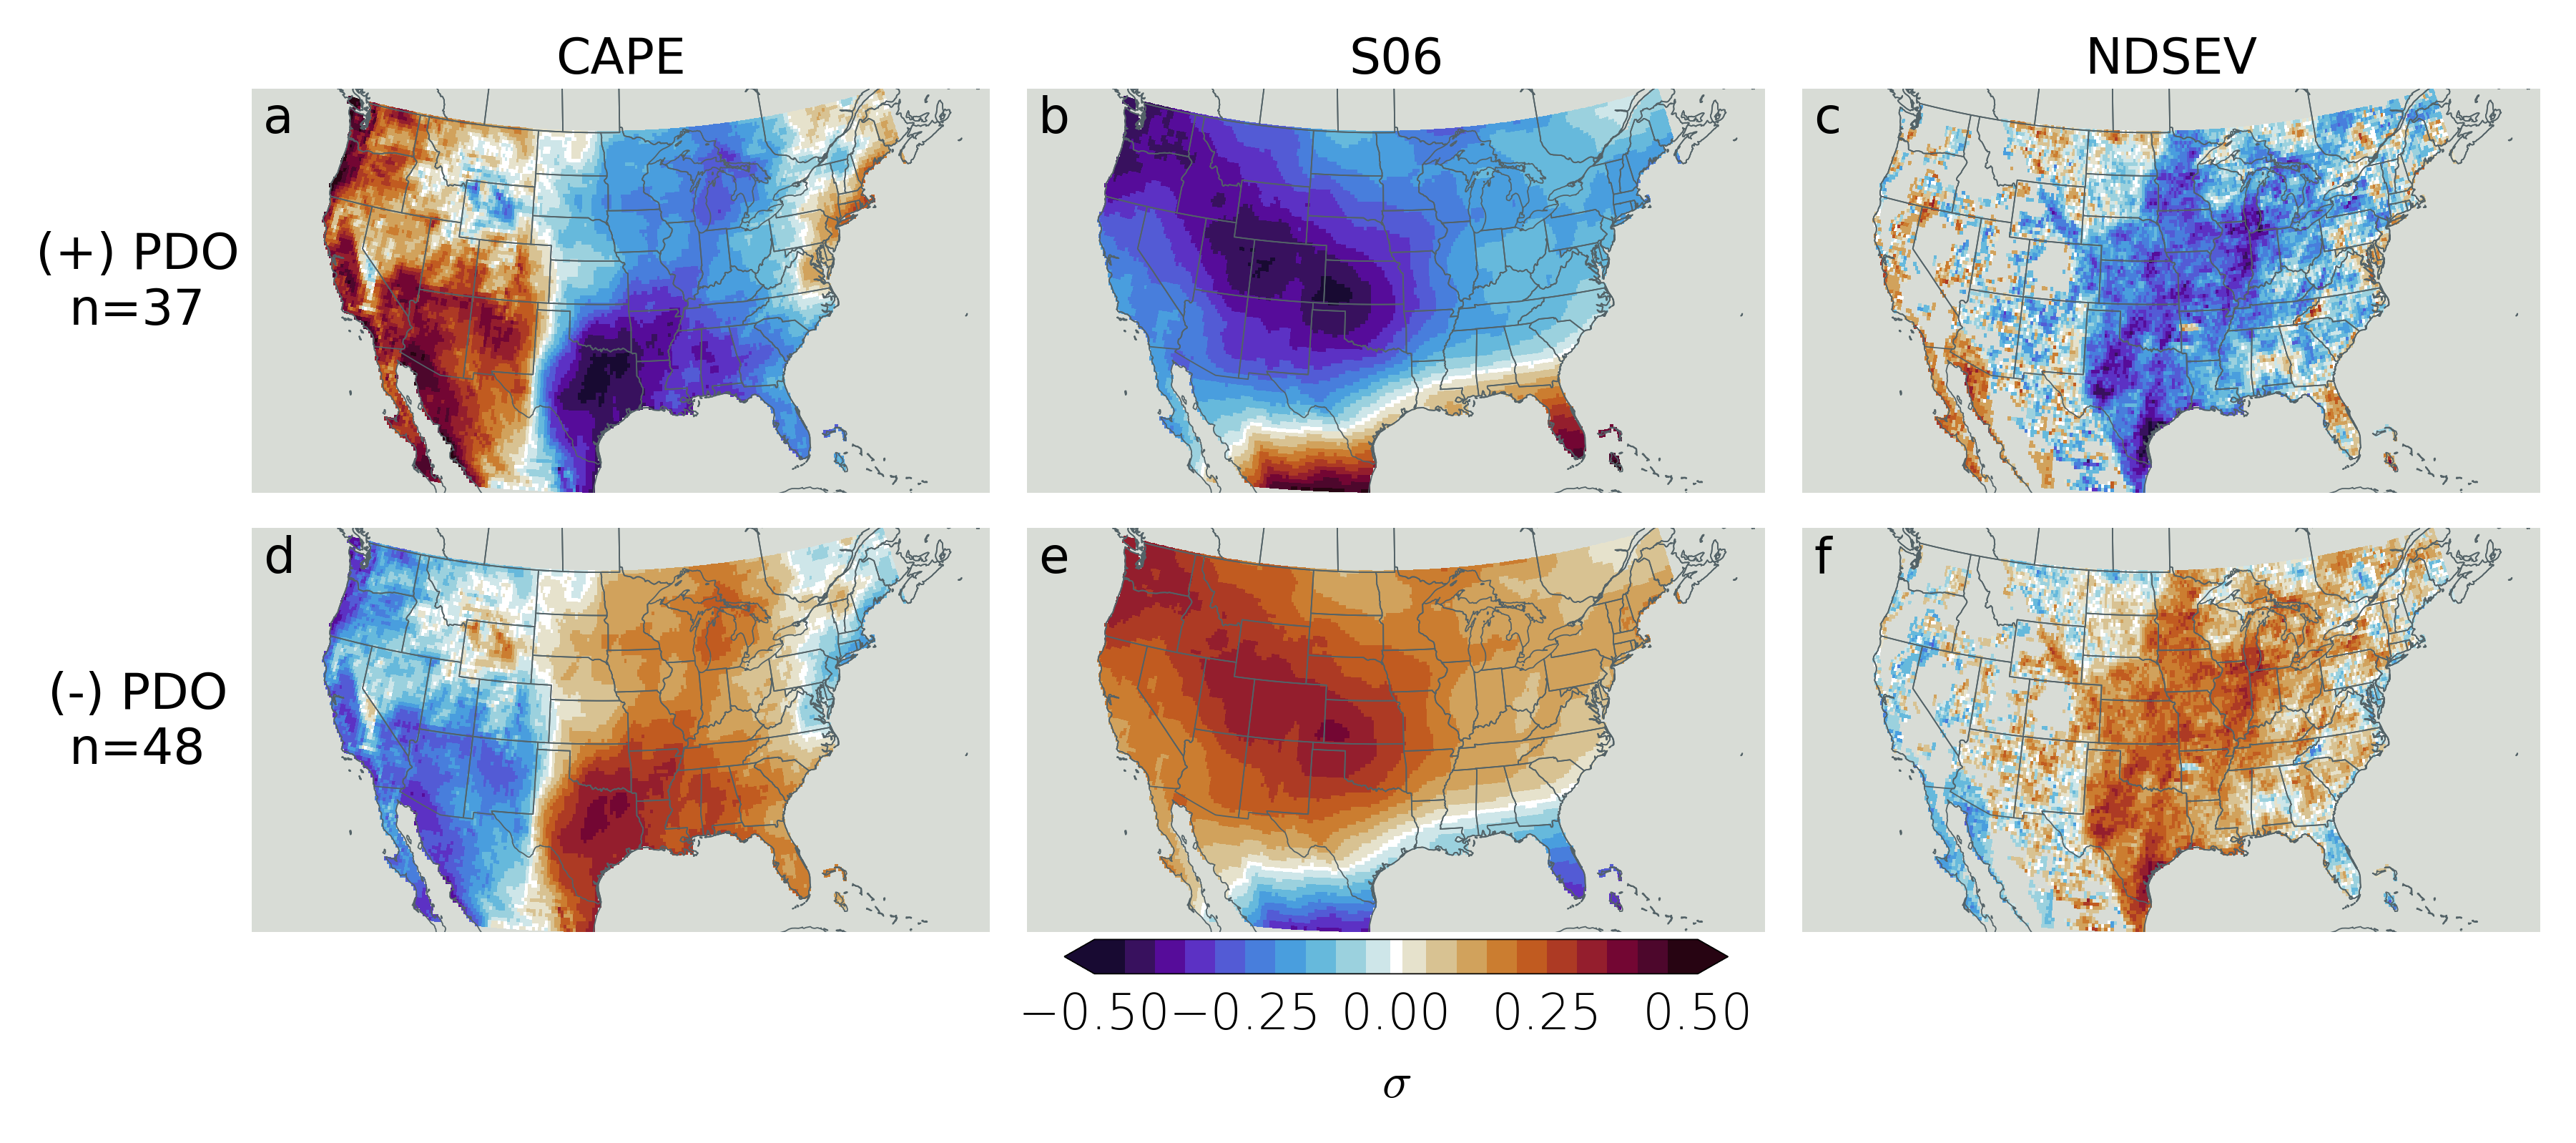

In [53]:
# Composite anomalies but in units of standard deviation
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

lon = ndsev['longitude']
lat = ndsev['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f']

cape_bounds = [-0.5, -0.45, -0.4, -0.35, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, -0.01, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[0].pcolormesh(lon, lat, (cape_pos_pdo.mean(dim='time') / cape_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')
ax[3].pcolormesh(lon, lat, (cape_neg_pdo.mean(dim='time') / cape_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')

ax[1].pcolormesh(lon, lat, (s06_pos_pdo.mean(dim='time') / s06_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')
ax[4].pcolormesh(lon, lat, (s06_neg_pdo.mean(dim='time') / s06_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')

ax[2].pcolormesh(lon, lat, (ndsev_pos_pdo.mean(dim='time') / ndsev_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')
ax[5].pcolormesh(lon, lat, (ndsev_neg_pdo.mean(dim='time') / ndsev_conus_mam_de.std(dim='time'))*land, transform=ccrs.PlateCarree(), norm=cape_norm, cmap='cmr.fusion_r')

cax = plt.axes([0.355, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-0.5, -0.25, 0, 0.25, 0.5])
cbar.set_label(r'$\sigma$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

ax[0].text(-3700000, -100000, f"(+) PDO\nn={len(cape_pos_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
# ax[3].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(cape_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"(-) PDO\nn={len(cape_neg_pdo)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

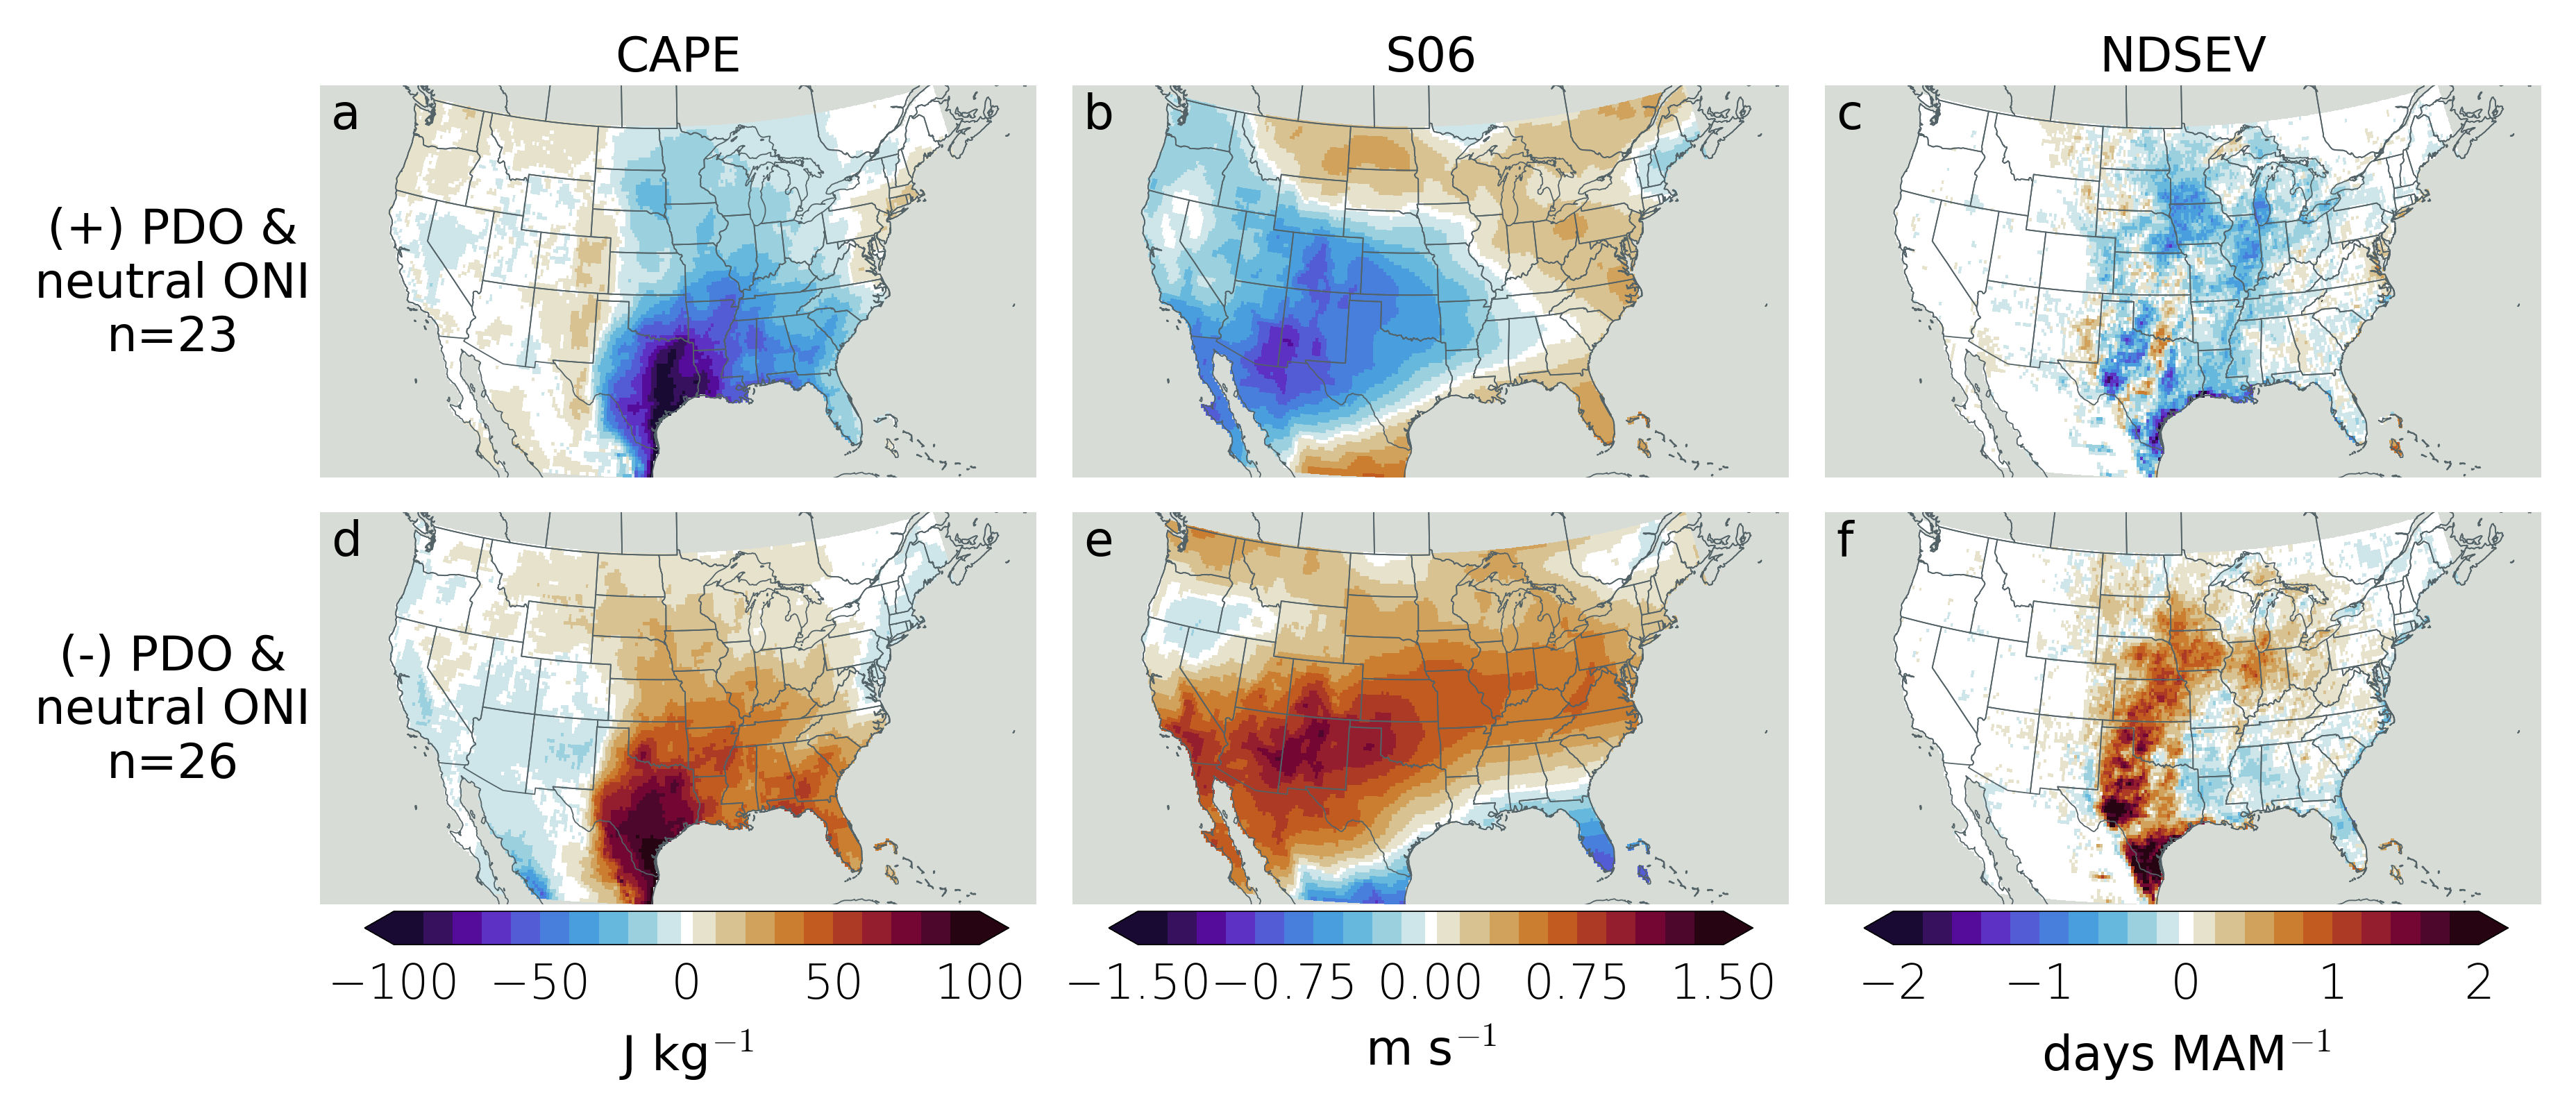

In [48]:
fig, ax = plt.subplots(2, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ndsev_bounds = [-2, -1.8, -1.6, -1.4, -1.2, -1, -0.8, -0.6, -0.4, -0.2, -0.05, 0.05, 0.2, 0.4, 0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2]
ndsev_norm = c.BoundaryNorm(ndsev_bounds, plt.get_cmap('cmr.fusion_r').N)

cape_bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cape_norm = c.BoundaryNorm(cape_bounds, plt.get_cmap('cmr.fusion_r').N)

s06_bounds = [-1.5, -1.35, -1.2, -1.05, -0.9, -0.75, -0.6, -0.45, -0.3, -0.15, -0.03, 0.03, 0.15, 0.3, 0.45, 0.6, 0.75, 0.9, 1.05, 1.2, 1.35, 1.5]
s06_norm = c.BoundaryNorm(s06_bounds, plt.get_cmap('cmr.fusion_r').N)

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2]]

lon = ndsev['longitude']
lat = ndsev['latitude']

letters = ['a', 'b', 'c', \
           'd', 'e', 'f']

for i in range(6):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1420000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, ndsev_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)
ax[5].pcolormesh(lon, lat, ndsev_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_norm)

ax[0].pcolormesh(lon, lat, cape_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)
ax[3].pcolormesh(lon, lat, cape_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_norm)

ax[1].pcolormesh(lon, lat, s06_pos_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)
ax[4].pcolormesh(lon, lat, s06_neg_pdo_neut_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_norm)

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

ax[0].text(-4000000, -400000, f"(+) PDO &\nneutral ONI\nn={len(cape_pos_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-4000000, -400000, f"(-) PDO &\nneutral ONI\nn={len(cape_neg_pdo_neut_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

ax[0].contourf(lon, lat, cape_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[3].contourf(lon, lat, cape_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[1].contourf(lon, lat, s06_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[4].contourf(lon, lat, s06_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

ax[2].contourf(lon, lat, ndsev_pos_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
ax[5].contourf(lon, lat, ndsev_neg_pdo_neut_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])


cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-100, -50, 0, 50, 100])
cbar.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-1.5, -0.75, 0, 0.75, 1.5])
cbar2.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-2, -1, 0, 1, 2])
cbar3.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

# lat_min, lat_max = 30, 47
# lon_min, lon_max = pdo_functions.convert_longitudes(-105), pdo_functions.convert_longitudes(-82)
# rect_lons = [lon_min, lon_max, lon_max, lon_min, lon_min]
# rect_lats = [lat_min, lat_min, lat_max, lat_max, lat_min]
# ax[2].plot(rect_lons, rect_lats, color='black', lw=1, transform=ccrs.PlateCarree())

mpl.rcParams['hatch.color'] = 'xkcd:gunmetal'
mpl.rcParams['hatch.linewidth'] = 0.375

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=0.75, 
                    wspace=0.05, 
                    hspace=0.05)

fig.savefig('/scratch/ivyglade/pdo/paper_figs/saved_pngs/FigS3_spatial_composite_neut_enso.png', bbox_inches='tight')

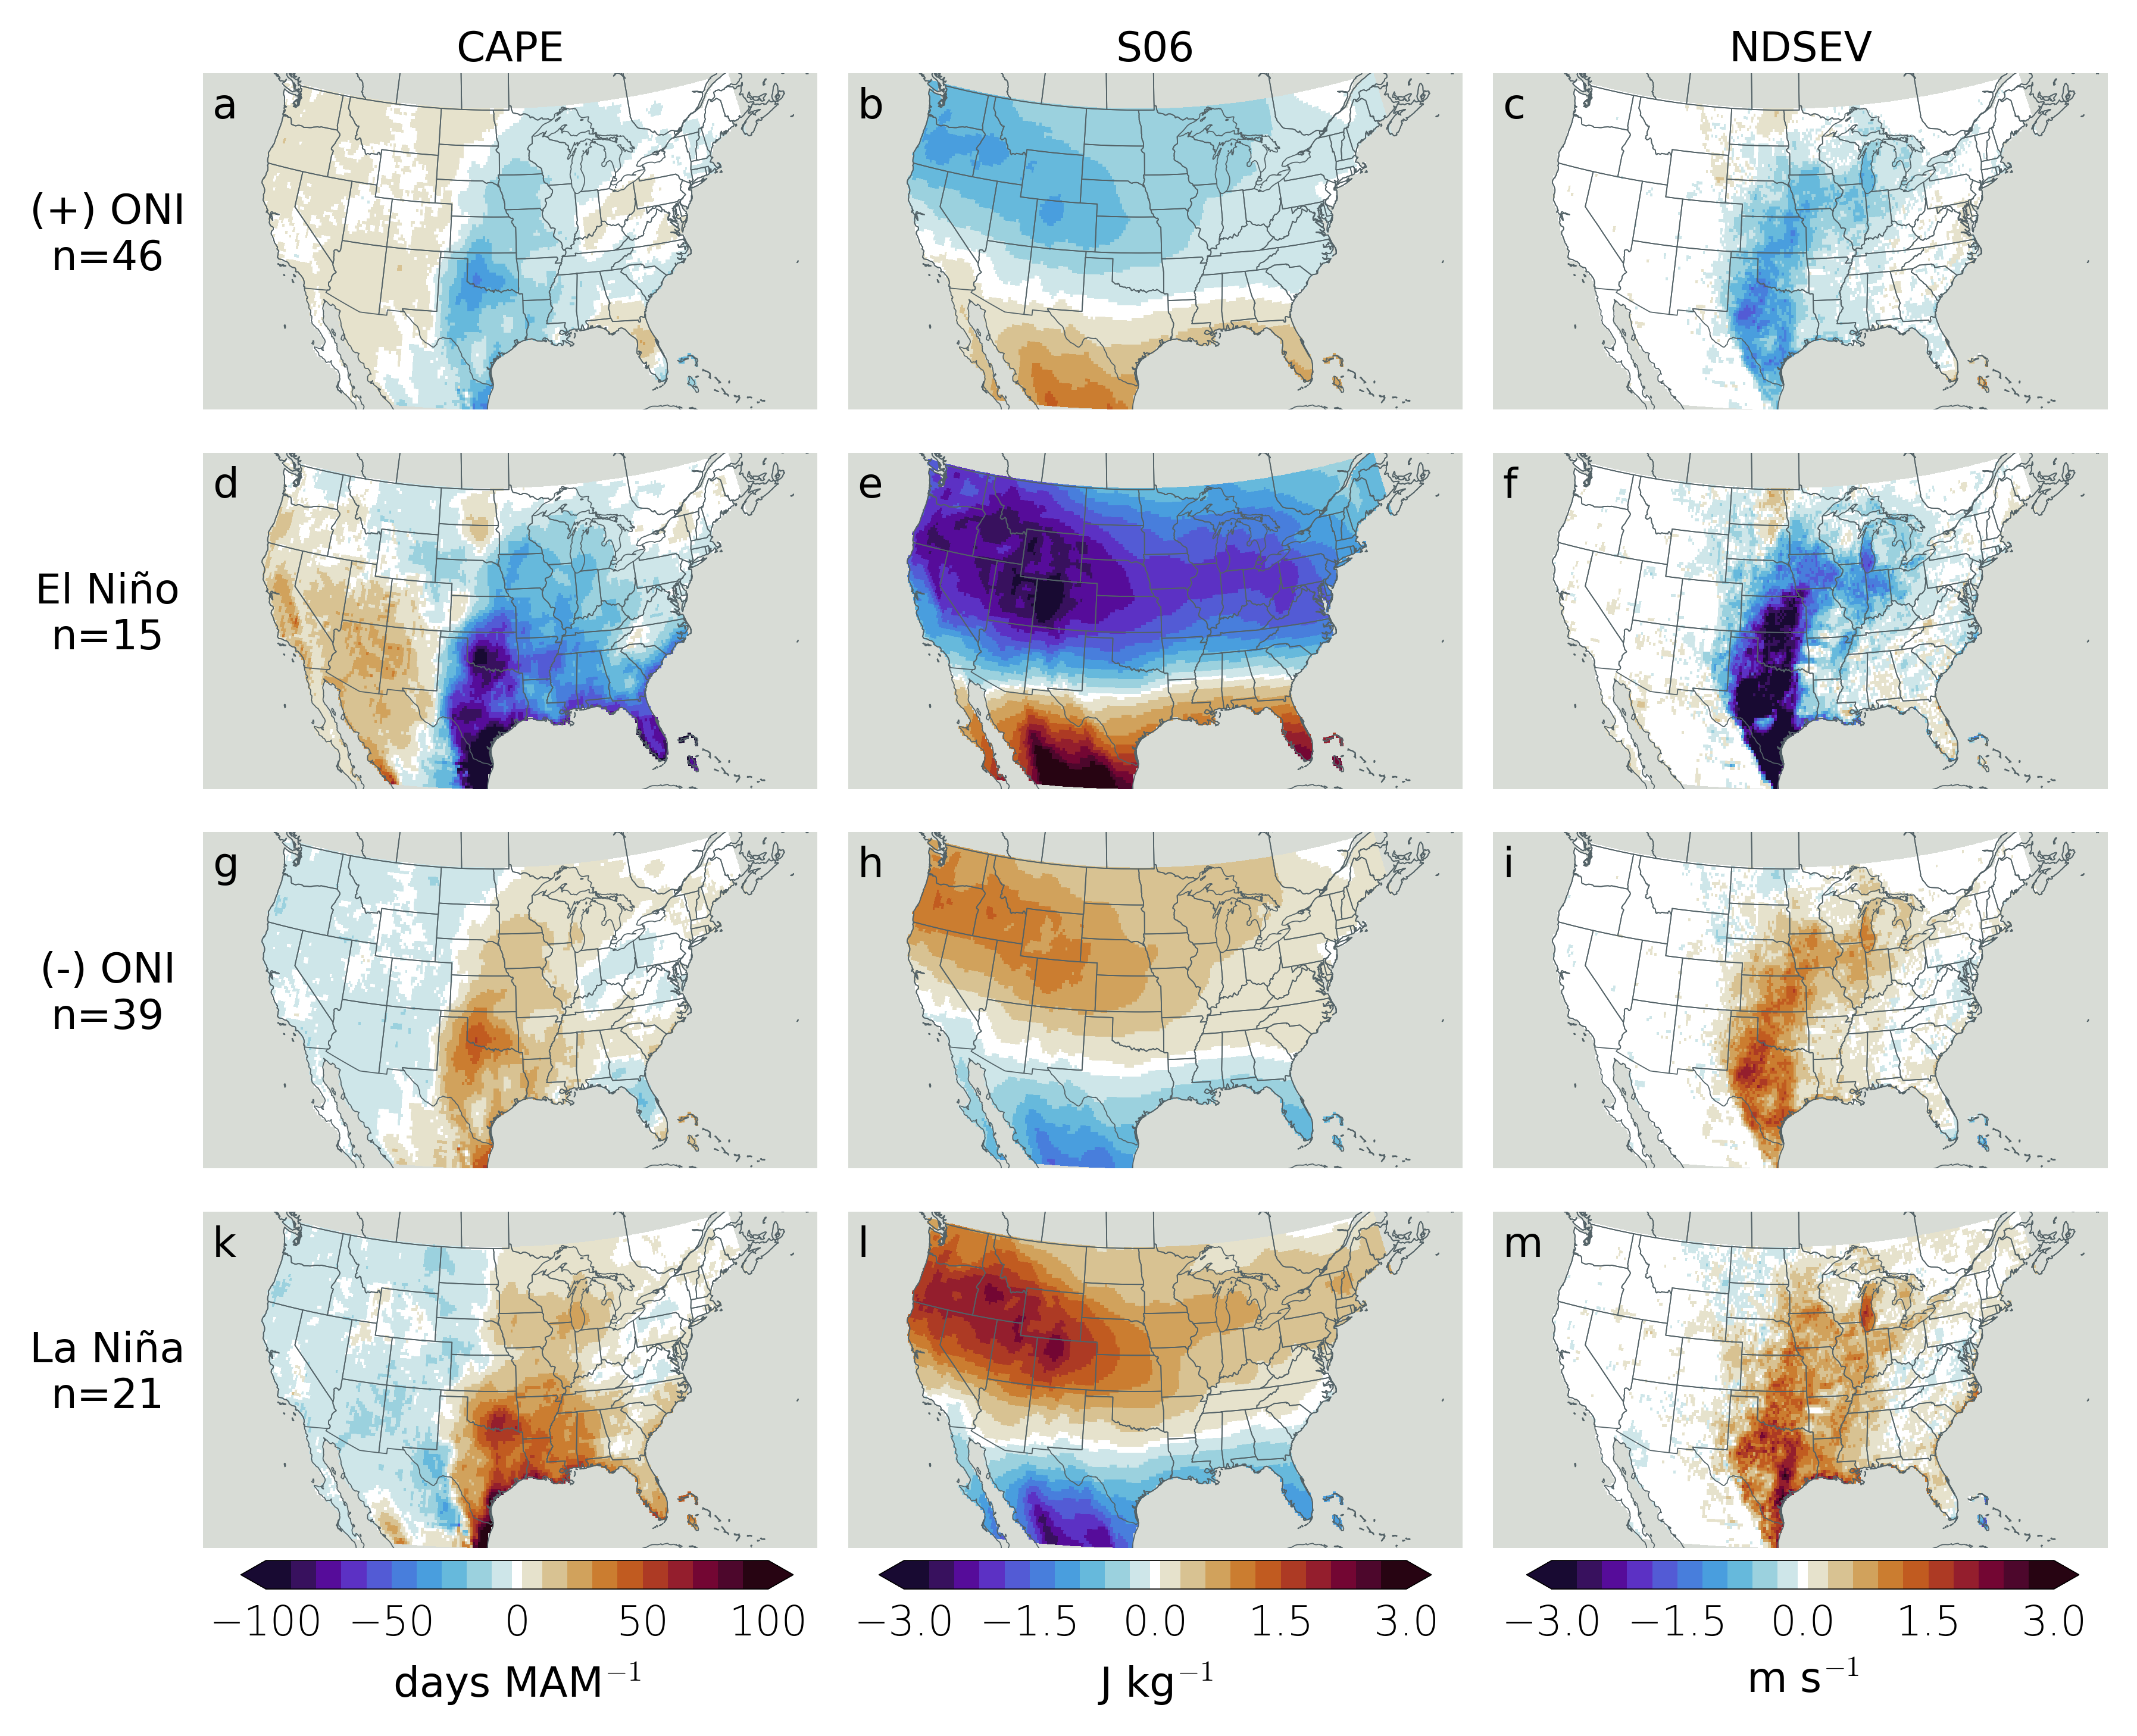

In [47]:
fig, ax = plt.subplots(4, 3, subplot_kw=dict(projection=ccrs.AlbersEqualArea(central_longitude=-97, central_latitude=36.5)))

ax = [ax[0, 0], ax[0, 1], ax[0, 2], \
      ax[1, 0], ax[1, 1], ax[1, 2], \
      ax[2, 0], ax[2, 1], ax[2, 2], \
      ax[3, 0], ax[3, 1], ax[3, 2]]

letters = ['a', 'b', 'c', \
           'd', 'e', 'f', \
           'g', 'h', 'i', \
           'k', 'l', 'm']

ndsev_nino_bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.06, 0.06, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]
ndsev_nino_norm = c.BoundaryNorm(ndsev_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

cape_nino_bounds = [-100, -90, -80, -70, -60, -50, -40, -30, -20, -10, -2, 2, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
cape_nino_norm = c.BoundaryNorm(cape_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

s06_nino_bounds = [-3, -2.7, -2.4, -2.1, -1.8, -1.5, -1.2, -0.9, -0.6, -0.3, -0.06, 0.06, 0.3, 0.6, 0.9, 1.2, 1.5, 1.8, 2.1, 2.4, 2.7, 3]
s06_nino_norm = c.BoundaryNorm(s06_nino_bounds, plt.get_cmap('cmr.fusion_r').N)

for i in range(12):
    ax[i].coastlines(lw=0.25, color='xkcd:gunmetal')
    ax[i].spines['geo'].set_edgecolor('xkcd:gunmetal')
    ax[i].spines['geo'].set_linewidth(0)
    ax[i].add_feature(ct.feature.STATES, lw=0.25, edgecolor='xkcd:gunmetal')
    ax[i].set_facecolor('xkcd:light gray')
    ax[i].text(-2700000, 1350000, letters[i], fontweight='normal', size=10)

ax[2].pcolormesh(lon, lat, ndsev_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[8].pcolormesh(lon, lat, ndsev_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[5].pcolormesh(lon, lat, ndsev_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)
ax[11].pcolormesh(lon, lat, ndsev_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=ndsev_nino_norm)

ax[0].pcolormesh(lon, lat, cape_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[6].pcolormesh(lon, lat, cape_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[3].pcolormesh(lon, lat, cape_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)
ax[9].pcolormesh(lon, lat, cape_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=cape_nino_norm)

ax[1].pcolormesh(lon, lat, s06_pos_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[7].pcolormesh(lon, lat, s06_neg_oni.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[4].pcolormesh(lon, lat, s06_pos_nino.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)
ax[10].pcolormesh(lon, lat, s06_neg_nina.mean(dim='time')*land, transform=ccrs.PlateCarree(), cmap='cmr.fusion_r', norm=s06_nino_norm)

ax[0].text(-3700000, -100000, f"(+) ONI\nn={len(cape_pos_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[6].text(-3700000, -100000, f"(-) ONI\nn={len(cape_neg_oni)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[3].text(-3700000, -100000, f"El Ni\u00f1o\nn={len(cape_pos_nino)}", fontweight='normal', size=10, rotation='horizontal', ha='center')
ax[9].text(-3700000, -100000, f"La Ni\u00f1a\nn={len(cape_neg_nina)}", fontweight='normal', size=10, rotation='horizontal', ha='center')

# ax[0].contourf(lon, lat, cape_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[3].contourf(lon, lat, cape_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[6].contourf(lon, lat, cape_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[9].contourf(lon, lat, cape_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[1].contourf(lon, lat, s06_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[4].contourf(lon, lat, s06_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[7].contourf(lon, lat, s06_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[10].contourf(lon, lat, s06_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])

# ax[2].contourf(lon, lat, ndsev_pos_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[5].contourf(lon, lat, ndsev_pos_nino_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[8].contourf(lon, lat, ndsev_neg_oni_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])
# ax[11].contourf(lon, lat, ndsev_neg_nina_sig*land, transform=ccrs.PlateCarree(), colors=['none', 'none'], levels=[0, 0.5, 1], hatches=[None, '////////////'])


cax = plt.axes([0.02, .23, 0.29, 0.02])
cbar = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=cape_nino_norm), cax=cax, orientation='horizontal', spacing='proportional', extend='both', \
                   ticks=[-100, -50, 0, 50, 100])
cbar.set_label(r'days MAM$^{-1}$', size=10, fontweight='normal', color='black')
cbar.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar.outline.set_linewidth(0.25)
cbar.outline.set_color('black')
# cbar.outline.set_visible(False)

cax2 = plt.axes([0.355, .23, 0.29, 0.02])
cbar2 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=s06_nino_norm), cax=cax2, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -1.5, 0, 1.5, 3])
cbar2.set_label(r'J kg$^{-1}$', size=10, fontweight='normal', color='black')
cbar2.ax.tick_params(which='both', labelsize=10, width=0.5, length=0, labelcolor='black')
cbar2.outline.set_linewidth(0.25)
cbar2.outline.set_color('black')
# cbar.outline.set_visible(False)

cax3 = plt.axes([0.695, .23, 0.29, 0.02])
cbar3 = plt.colorbar(mpl.cm.ScalarMappable(cmap='cmr.fusion_r', norm=ndsev_nino_norm), cax=cax3, orientation='horizontal', spacing='proportional', extend='both', \
                    ticks=[-3, -1.5, 0, 1.5, 3])
cbar3.set_label(r'm s$^{-1}$', size=10, fontweight='normal', color='black')
cbar3.ax.tick_params(which='both', labelsize=10, width=0.25, length=0, labelcolor='black')
cbar3.outline.set_linewidth(0.25)
cbar3.outline.set_color('black')
# cbar.outline.set_visible(False)

ax[2].set_title('NDSEV', pad=3, fontsize=10)
ax[0].set_title('CAPE', pad=3, fontsize=10)
ax[1].set_title('S06', pad=3, fontsize=10)

plt.subplots_adjust(left=0,
                    bottom=0.25, 
                    right=1., 
                    top=1.3, 
                    wspace=0.05, 
                    hspace=0.05)